# Preprocessing

Imports

In [ ]:
import numpy             as np
import matplotlib.pyplot as plt
import tensorflow        as tf

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
import shutil
import random
import os

Importing Drive and unzipinig the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


# SECOND DATA SET

!unzip drive/MyDrive/Eye/OCT_20
#!tar xvzf drive/MyDrive/Eye/file_downloaded

Streaming output truncated to the last 5000 lines.
  inflating: OCT_20/train/NORMAL/NORMAL-1045896-1.jpeg  
  inflating: OCT_20/train/NORMAL/NORMAL-1045896-2.jpeg  
  inflating: OCT_20/train/NORMAL/NORMAL-1045896-3.jpeg  
  inflating: OCT_20/train/NORMAL/NORMAL-1045896-4.jpeg  
  inflating: OCT_20/train/NORMAL/NORMAL-1047298-1.jpeg  
  inflating: OCT_20/train/NORMAL/NORMAL-1047298-2.jpeg  
  inflating: OCT_20/train/NORMAL/NORMAL-1047298-3.jpeg  
  inflating: OCT_20/train/NORMAL/NORMAL-1047298-4.jpeg  
  inflating: OCT_20/train/NORMAL/NORMAL-1047298-5.jpeg  
  inflating: OCT_20/train/NORMAL/NORMAL-1047298-6.jpeg  
  inflating: OCT_20/train/NORMAL/NORMAL-1047298-7.jpeg  
  inflating: OCT_20/train/NORMAL/NORMAL-1047298-8.jpeg  
  inflating: OCT_20/train/NORMAL/NORMAL-1047578-1.jpeg  
  inflating: OCT_20/train/NORMAL/NORMAL-1047578-2.jpeg  
  inflating: OCT_20/train/NORMAL/NORMAL-1047578-3.jpeg  
  inflating: OCT_20/train/NORMAL/NORMAL-1052624-1.jpeg  
  inflating: OCT_20/train/NORMAL/NORM

Determining the batch size

In [ ]:
batch_size = 8

Defining the data generators

In [ ]:

Normal_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale            = 1./255,
    rotation_range     = 8,
    width_shift_range  = 0.1,
    height_shift_range = 0.1
)

CNV_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale            = 1./255,
    rotation_range     = 8,
    width_shift_range  = 0.1,
    height_shift_range = 0.1
)

DRUSSEN_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale            = 1./255,
    rotation_range     = 8,
    width_shift_range  = 0.1,
    height_shift_range = 0.1
)

In [ ]:
Normal_data = Normal_datagen.flow_from_directory(
    'OCT_20/train/NORMALD',
    target_size = (256,256),
    batch_size  = batch_size,
    color_mode  = "grayscale",
    class_mode  = None,
    shuffle     = True
)

Found 5263 images belonging to 2 classes.


In [ ]:
CNV_data = CNV_datagen.flow_from_directory(
    'OCT_20/train/CNVD',
    target_size = (256,256),
    batch_size  = batch_size,
    color_mode  = "grayscale",
    class_mode  = None,
    shuffle     = True
)

Found 7481 images belonging to 2 classes.


In [ ]:
DRUSSEN_data = DRUSSEN_datagen.flow_from_directory(
    'OCT_20/train/DRUSEND',
    target_size = (256,256),
    batch_size  = batch_size,
    color_mode  = "grayscale",
    class_mode  = None,
    shuffle     = True
)

Found 1723 images belonging to 2 classes.


In [ ]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale            = 1./255
)

test_data = test_datagen.flow_from_directory(
    'OCT_20/test/V',
    target_size = (256,256),
    batch_size  = batch_size ,
    color_mode  = "grayscale",
    class_mode  = "categorical",
)

Found 750 images belonging to 3 classes.


#Building the Model

Defining the Custom Activation Function

In [ ]:
# custom activation function
def custom_activation(output):
  logexpsum = tf.keras.backend.sum(tf.keras.backend.exp(output), axis=-1, keepdims=True)
  result    = logexpsum / (logexpsum + 1.0)

  return result

Defining Discriminator and the Classification model

In [ ]:
def define_discriminator(in_shape=(256,256,1), n_classes=3):
  in_image = tf.keras.layers.Input(shape=in_shape)

  fe = tf.keras.layers.Conv2D(128, (3,3), strides = (1,1), padding = "same")(in_image)
  fe = tf.keras.layers.MaxPool2D(pool_size = (2,2) , strides = (2,2))(fe)
  fe = tf.keras.layers.LeakyReLU(alpha=0.2)(fe)

  fe = tf.keras.layers.Dropout(0.1)(fe)

  fe = tf.keras.layers.Conv2D(128, (3,3), strides = (1,1), padding = "same")(fe)
  fe = tf.keras.layers.MaxPool2D(pool_size = (2,2) , strides = (2,2))(fe)
  fe = tf.keras.layers.LeakyReLU(alpha=0.2)(fe)

  fe = tf.keras.layers.Dropout(0.1)(fe)

  fe = tf.keras.layers.Conv2D(128, (3,3), strides = (1,1), padding = "same")(fe)
  fe = tf.keras.layers.MaxPool2D(pool_size = (2,2) , strides = (2,2))(fe)
  fe = tf.keras.layers.LeakyReLU(alpha=0.2)(fe)

  fe = tf.keras.layers.Dropout(0.1)(fe)

  fe = tf.keras.layers.Conv2D(128, (3,3), strides = (1,1), padding = "same")(fe)
  fe = tf.keras.layers.MaxPool2D(pool_size = (2,2) , strides = (2,2))(fe)
  fe = tf.keras.layers.LeakyReLU(alpha=0.2)(fe)

  fe = tf.keras.layers.Flatten()(fe)
  fe = tf.keras.layers.Dropout(0.1)(fe)
  fe = tf.keras.layers.Dense(n_classes)(fe)

  c_out_layer = tf.keras.layers.Activation("softmax")(fe)
  c_model     = tf.keras.models.Model(in_image, c_out_layer)
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.001, 50, 0.96, staircase=True, name=None)
  c_model.compile(loss = "categorical_crossentropy", optimizer = tf.keras.optimizers.Adam(learning_rate =lr_schedule,  beta_1 = 0.5), metrics = ["accuracy"])

  d_out_layer = tf.keras.layers.Lambda(custom_activation)(fe)
  d_model     = tf.keras.models.Model(in_image, d_out_layer)
  d_model.compile(loss = "binary_crossentropy", optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule , beta_1 = 0.5))
  return d_model, c_model

Defining the Generator

In [ ]:
def define_generator(latent_dim):
  in_lat  = tf.keras.layers.Input(shape=(latent_dim,))
  n_nodes = 128 * 8 * 8

  gen = tf.keras.layers.Dense(n_nodes)(in_lat)
  gen = tf.keras.layers.LeakyReLU(alpha = 0.2)(gen)
  gen = tf.keras.layers.Reshape((8, 8, 128))(gen)

  gen = tf.keras.layers.Conv2DTranspose(128, (4,4), strides = (2,2), padding = "same")(gen)
  gen = tf.keras.layers.LeakyReLU(alpha = 0.2)(gen)

  gen = tf.keras.layers.Conv2DTranspose(128, (4,4), strides = (2,2), padding = "same")(gen)
  gen = tf.keras.layers.LeakyReLU(alpha = 0.2)(gen)

  gen = tf.keras.layers.Conv2DTranspose(128, (4,4), strides = (2,2), padding = "same")(gen)
  gen = tf.keras.layers.LeakyReLU(alpha = 0.2)(gen)

  gen = tf.keras.layers.Conv2DTranspose(128, (4,4), strides = (2,2), padding = "same")(gen)
  gen = tf.keras.layers.LeakyReLU(alpha = 0.2)(gen)

  gen = tf.keras.layers.Conv2DTranspose(128, (4,4), strides = (2,2), padding = "same")(gen)
  gen = tf.keras.layers.LeakyReLU(alpha = 0.2)(gen)

  out_layer = tf.keras.layers.Conv2D(1, (7,7), activation = "sigmoid", padding = "same")(gen)

  model = tf.keras.models.Model(in_lat, out_layer)
  return model

Defining GAN

In [ ]:
def define_gan(g_model, d_model):
  d_model.trainable = False

  gan_output = d_model(g_model.output)
  model      = tf.keras.models.Model(g_model.input, gan_output)
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.001, 50, 0.96, staircase=True, name=None)
  opt        = tf.keras.optimizers.Adam(learning_rate = lr_schedule, beta_1 = 0.5)
  model.compile(loss="binary_crossentropy", optimizer=opt)

  return model

How to generate real samples

In [ ]:
def generate_real_samples():
  X_Normal  = Normal_data.next()
  Y_Normal  = np.array([0,0,1] * X_Normal.shape[0]).reshape(X_Normal.shape[0], -1)
  X_CNV     = CNV_data.next()
  Y_CNV     = np.array([1,0,0] * X_CNV.shape[0]).reshape(X_CNV.shape[0], -1)
  X_DRUSSEN = DRUSSEN_data.next()
  Y_DRUSSEN = np.array([0,1,0] * X_DRUSSEN.shape[0]).reshape(X_DRUSSEN.shape[0], -1)

  X       = np.concatenate([ X_Normal, X_CNV, X_DRUSSEN])
  labels  = np.concatenate([ Y_Normal, Y_CNV, Y_DRUSSEN])
  y       = np.ones((X.shape[0], 1))

  return [X, labels], y

How to generate fake samples

In [ ]:
def generate_latent_points(latent_dim, n_samples):
  z_input = np.random.randn(latent_dim * n_samples)
  z_input = z_input.reshape(n_samples, latent_dim)
  return z_input

def generate_fake_samples(generator, latent_dim, n_samples):
  z_input = generate_latent_points(latent_dim, n_samples)
  images  = generator.predict(z_input)
  y       = np.zeros((n_samples, 1))
  return images, y

#Training the Model

Defining the train function

In [ ]:
def train(g_model, d_model, c_model, gan_model, latent_dim, n_epochs , batch_size):
  bat_per_epo = int(14467 / (3 * batch_size))

  for i in range(bat_per_epo * n_epochs):
    [Xsup_real, ysup_real], y_real = generate_real_samples()
    c_loss, c_acc                  = c_model.train_on_batch(Xsup_real, ysup_real)

    d_loss1        = d_model.train_on_batch(Xsup_real, y_real)
    X_fake, y_fake = generate_fake_samples(g_model, latent_dim, 3 * batch_size)
    d_loss2        = d_model.train_on_batch(X_fake, y_fake)

    X_gan, y_gan = generate_latent_points(latent_dim, 3 * batch_size), np.ones((3 * batch_size, 1))
    g_loss       = gan_model.train_on_batch(X_gan, y_gan)

    print(">%d, c[%.3f,%.0f], d[%.3f,%.3f], g[%.3f]" % (i+1, c_loss, c_acc*100, d_loss1, d_loss2, g_loss))

  return c_model.evaluate(test_data)

Defining the models and latent dimension

In [ ]:
latent_dim = 100

d_model, c_model = define_discriminator()
g_model          = define_generator(latent_dim)
gan_model        = define_gan(g_model, d_model)

Loading model weights

In [ ]:
d_model.load_weights('/content/drive/MyDrive/GAN_20p/OTHER_TO_3/saved_model/d_model_3class_99')
c_model.load_weights('/content/drive/MyDrive/GAN_20p/OTHER_TO_3/saved_model/c_model_3class_99')
g_model.load_weights('/content/drive/MyDrive/GAN_20p/OTHER_TO_3/saved_model/g_model_3class_99')

Training the model and saving the Accuracy and Loss of test data in history

In [ ]:
history = list()

In [ ]:
history.append(train(g_model, d_model, c_model, gan_model, latent_dim, n_epochs = 1, batch_size = batch_size))

1/1 [==============================] - 0s 20ms/step
>1, c[0.402,92], d[0.653,0.538], g[1.314]
1/1 [==============================] - 0s 23ms/step
>2, c[0.403,83], d[0.523,0.433], g[1.396]
1/1 [==============================] - 0s 34ms/step
>3, c[0.440,79], d[0.191,0.602], g[1.662]
1/1 [==============================] - 0s 20ms/step
>4, c[0.344,83], d[0.438,0.360], g[1.870]
1/1 [==============================] - 0s 20ms/step
>5, c[0.670,67], d[0.484,0.308], g[1.880]
1/1 [==============================] - 0s 20ms/step
>6, c[0.188,96], d[0.509,0.326], g[1.962]
1/1 [==============================] - 0s 19ms/step
>7, c[0.787,67], d[0.392,0.307], g[1.756]
1/1 [==============================] - 0s 29ms/step
>8, c[0.268,88], d[0.543,0.577], g[1.885]
1/1 [==============================] - 0s 20ms/step
>9, c[0.318,92], d[0.436,0.277], g[1.981]
1/1 [==============================] - 0s 20ms/step
>10, c[0.718,75], d[0.422,0.330], g[2.185]
1/1 [==============================] - 0s 20ms/step
>11, c[

Evaluting C-Model on the test data

In [ ]:
c_model.evaluate(test_data)

94/94 [==============================] - 3s 27ms/step - loss: 0.0452 - accuracy: 0.9907


[0.045226603746414185, 0.9906666874885559]

Saving Weights

In [ ]:
#!mkdir -p saved_model/d_model/w
#!mkdir -p saved_model/c_model/w
#!mkdir -p saved_model/g_model/w

d_model.save_weights('/content/drive/MyDrive/GAN_20p/OTHER_TO_3/saved_model/new_d_model_3class_97')
c_model.save_weights('/content/drive/MyDrive/GAN_20p/OTHER_TO_3/saved_model/new_c_model_3class_947')
g_model.save_weights('/content/drive/MyDrive/GAN_20p/OTHER_TO_3/saved_model/new_g_model_3class_94')

In [ ]:
bytearray([43])

bytearray(b'+')

# Testing Generative Model

1/1 [==============================] - 0s 24ms/step


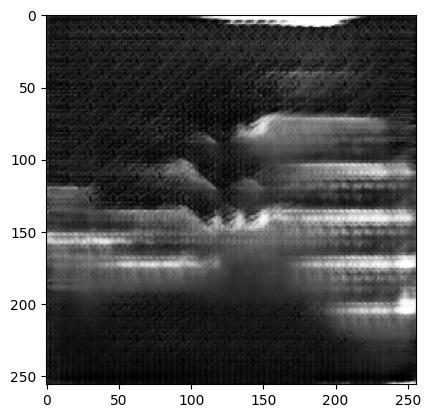

In [ ]:
fake = g_model.predict(generate_latent_points(100, 2))
plt.imshow(fake[0,:,:,0], cmap= "gray")

In [ ]:
y_pred = c_model.predict(test_data)


750/750 [==============================] - 3s 4ms/step


In [ ]:
predicted_categories = tf.argmax(y_pred, axis=1)
true=[]
predicted=[]
for index , (image,label) in enumerate(test_data):
  if index== 750:
    break
  true.append(label)
  predicted.append(c_model.predict(image))

1/1 [==============================] - 0s 27ms/step


In [ ]:
predicted

[array([[2.0763088e-07, 8.1424584e-04, 9.9918550e-01]], dtype=float32),
 array([[0.00120458, 0.05568082, 0.9431146 ]], dtype=float32),
 array([[0.00908783, 0.9695097 , 0.02140243]], dtype=float32),
 array([[0.759969  , 0.22936475, 0.01066627]], dtype=float32),
 array([[0.45182252, 0.5443544 , 0.00382303]], dtype=float32),
 array([[0.92425686, 0.07341345, 0.0023296 ]], dtype=float32),
 array([[0.04068654, 0.90057987, 0.05873356]], dtype=float32),
 array([[0.08781514, 0.8979737 , 0.01421126]], dtype=float32),
 array([[4.0771502e-06, 3.5999655e-03, 9.9639601e-01]], dtype=float32),
 array([[1.4709009e-04, 2.1915622e-02, 9.7793728e-01]], dtype=float32),
 array([[0.66298914, 0.3321008 , 0.00491006]], dtype=float32),
 array([[0.02617565, 0.80000603, 0.17381826]], dtype=float32),
 array([[6.3203464e-05, 4.4618573e-02, 9.5531821e-01]], dtype=float32),
 array([[0.90149003, 0.09354283, 0.00496716]], dtype=float32),
 array([[7.7784481e-04, 9.4595844e-01, 5.3263701e-02]], dtype=float32),
 array([[7

In [ ]:

#true_categories = tf.concat(z[0:750], axis=0)
predicted_categories = tf.argmax(predicted, axis=1)

In [ ]:
true_cat= []
for item in true:
  true_cat.append(np.argmax(item))

In [ ]:
predicted_cat= []
for item in predicted:
  predicted_cat.append(np.argmax(item))
confusion_matrix(predicted_cat, true_cat)

array([[225,  17,   0],
       [ 22, 217,  10],
       [  0,  15, 244]])

In [ ]:
true_cat


[0,
 1,
 1,
 1,
 0,
 2,
 2,
 0,
 1,
 2,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 2,
 1,
 1,
 0,
 1,
 2,
 2,
 1,
 1,
 1,
 2,
 0,
 2,
 1,
 1,
 1,
 0,
 0,
 2,
 0,
 2,
 2,
 0,
 1,
 1,
 0,
 2,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 2,
 1,
 0,
 0,
 2,
 2,
 0,
 1,
 0,
 2,
 2,
 2,
 0,
 2,
 2,
 1,
 0,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 0,
 0,
 0,
 2,
 1,
 1,
 2,
 2,
 1,
 0,
 2,
 2,
 1,
 1,
 1,
 1,
 2,
 0,
 1,
 2,
 2,
 1,
 2,
 2,
 0,
 1,
 1,
 1,
 1,
 2,
 0,
 2,
 2,
 2,
 0,
 0,
 0,
 2,
 1,
 1,
 0,
 2,
 1,
 2,
 0,
 0,
 1,
 1,
 0,
 1,
 2,
 0,
 2,
 0,
 0,
 2,
 2,
 1,
 2,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 2,
 1,
 2,
 2,
 2,
 0,
 0,
 0,
 2,
 2,
 2,
 0,
 0,
 1,
 0,
 2,
 1,
 2,
 0,
 0,
 2,
 1,
 2,
 1,
 2,
 0,
 2,
 1,
 1,
 1,
 0,
 2,
 0,
 0,
 2,
 1,
 0,
 0,
 1,
 2,
 0,
 0,
 0,
 1,
 2,
 1,
 0,
 0,
 2,
 0,
 1,
 2,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 2,
 1,
 2,
 2,
 2,
 2,
 1,
 0,
 1,
 1,
 2,
 0,
 0,
 0,
 2,
 0,
 2,
 2,
 0,
 1,
 1,


In [ ]:
predicted_cat

[2,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 0,
 0,
 0,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 2,
 0,
 0,
 1,
 0,
 0,
 0,
 2,
 2,
 0,
 1,
 2,
 2,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 2,
 0,
 2,
 2,
 2,
 0,
 0,
 1,
 2,
 1,
 1,
 2,
 2,
 0,
 1,
 2,
 2,
 0,
 0,
 0,
 2,
 1,
 2,
 0,
 1,
 1,
 0,
 2,
 2,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 2,
 2,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 2,
 1,
 2,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 2,
 1,
 0,
 0,
 0,
 1,
 2,
 2,
 0,
 2,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 2,
 0,
 1,
 0,
 2,
 0,
 1,
 0,
 2,
 2,
 2,
 0,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 0,
 0,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 1,
 0,
 1,
 1,
 2,
 0,
 0,
 1,
 0,
 2,
 1,
 1,
 0,
 2,
 2,
 0,
 1,
 2,
 2,
 0,
 2,
 0,
 1,
 1,
 1,
 2,
 0,
 0,
 2,
 2,
 0,
 1,
 2,
 1,
 2,
 1,
 1,
 0,
 0,
 2,
 2,
 1,
 2,
 0,
 2,
 2,
 0,
 2,
 0,
 1,
 2,
 1,
 1,
 2,
 0,
 1,
 2,
 2,
 1,
 2,
 2,
 0,
 1,
 0,
 1,
 1,
 2,
 0,
 0,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 2,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 2,
 1,
 1,
 2,
 2,
 2,
 0,
 2,


In [ ]:
true_categories = tf.concat(z[0:750], axis=0)

NameError: ignored

In [ ]:
g_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_3 (Dense)             (None, 8192)              827392    
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 8192)              0         
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                                       
                                                                 
 batch_normalization_13 (Bat  (None, 16, 16, 128)      512       
 chNormalization)                                          

In [ ]:
#gen = tf.keras.layers.Dropout(0.4)(gen)
#fe = tf.keras.layers.Activation('swish')(fe)
 #fe = tf.keras.layers.Activation('swish')(fe)
   #fe = tf.keras.layers.BatchNormalization()(fe)
  #fe = tf.keras.layers.Dropout(0.7)(fe)